In [15]:
import torch
from torch_geometric.data import Data, DataLoader, Dataset
import torch.nn.functional as F
import random 
import networkx as nx
import numpy as np
from torch_geometric.nn import NNConv
from torch.nn import Linear
from matplotlib import pyplot as plt
import torch.nn as nn

In [2]:
torch.cuda.is_available()

True

In [61]:
def generate_polygon(n, radius=1):
    node_pos = [(radius * np.cos(2 * np.pi * i / n),
                 radius * np.sin(2 * np.pi * i / n)) for i in range(n)]
    x = torch.tensor(node_pos,dtype=torch.float)
    return x

def generate_randPos(n, radius=1):
    node_pos = [(random.uniform(-1, 1),
                 random.uniform(-1, 1)) for i in range(n)]
    x = torch.tensor(node_pos,dtype=torch.float)
    return x

def generate_edgelist(size):
    return [(i, j) for i in range(size) for j in range(i + 1, size)]

def node2edge(node_pos, batch):
    # find sizes for each graph in batch
    graph_sizes = list(map(lambda d: d.x.size()[0], batch.to_data_list()))
    # get split indices
    start_idx = np.insert(np.cumsum(graph_sizes), 0, 0)
    start_pos = []
    end_pos = []
    for i, num_nodes in enumerate(graph_sizes):
        # get edge list for current graph
        edgelist = np.array(generate_edgelist(num_nodes))
        # get node positions for current graph
        graph_node_pos = node_pos[start_idx[i]:start_idx[i+1]]
        # get edge start positions for current graph
        start_pos += [graph_node_pos[edgelist[:, 0]]]
        # get edge end positions for current graph
        end_pos += [graph_node_pos[edgelist[:, 1]]]
    # concatenate the results
    return torch.cat(start_pos, 0), torch.cat(end_pos, 0)

def generate_eAttr(G, com_edge_list):
    path_length = dict(nx.all_pairs_shortest_path_length(G))
    max_length = 0
    for source in path_length:
        for target in path_length[source]:
            if path_length[source][target] > max_length:
                max_length = path_length[source][target]
    L = 2/max_length
    K = 1
    edge_attr = []
    for i in com_edge_list:
        d = path_length[i[0]][i[1]]
        l = L * d #l = L * d
        k = K/(d**2) 
        edge_attr.append([l,k])
    out = torch.tensor(edge_attr, dtype=torch.float)
    return out

def generate_graph(size):
    while True:
        G = nx.binomial_graph(size, random.random(),directed=False)
#         G = nx.random_powerlaw_tree(size,3,tries=10000)
        com_edge_list = generate_edgelist(size)
        try:
            edge_attr = generate_eAttr(G, com_edge_list)
        except KeyError:
            continue
        except ZeroDivisionError:
            continue
#         nx.write_edgelist(G, file_name, data=False)
        edge_index = torch.tensor(com_edge_list, dtype=torch.long)
        x = generate_randPos(size)
        data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)
        return G, data

def generate_testgraph(size,prob):
    while True:
        G = nx.binomial_graph(size, prob,directed=False)
#         G = nx.random_powerlaw_tree(size,3,tries=10000)
        com_edge_list = generate_edgelist(size)
        try:
            edge_attr = generate_eAttr(G, com_edge_list)
        except KeyError:
            continue
        except ZeroDivisionError:
            continue
#         nx.write_edgelist(G, file_name, data=False)
        edge_index = torch.tensor(com_edge_list, dtype=torch.long)
        x = generate_randPos(size)
        data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)
        return G, data


class EnergyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, data_batch):
        energy = 0
        offset = 0
        for data in data_batch.to_data_list():
            edge_attr = data.edge_attr
            n = data.x.size()[0]
            x = p[offset:offset+n, 0]
            y = p[offset:offset+n, 1]
            offset += n
            l = edge_attr[:, 0]
            k = edge_attr[:, 1]
            for e, (i, j) in enumerate(generate_edgelist(n)):
                term1 = (x[i] - x[j]) ** 2
                term2 = (y[i] - y[j]) ** 2
                term3 = l[e] ** 2
                term4 = 2 * l[e] * (term1 + term2).sqrt()
                energy += k[e] / 2 * (term1 + term2 + term3 - term4)
        return energy

    
class EnergyLossVectorized(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, data):
        edge_attr = data.edge_attr
        # convert per-node positions to per-edge positions
        start, end = node2edge(p, data)
        
        start_x = start[:, 0]
        start_y = start[:, 1]
        end_x = end[:, 0]
        end_y = end[:, 1]
        
        l = edge_attr[:, 0]
        k = edge_attr[:, 1]
        
        term1 = (start_x - end_x) ** 2
        term2 = (start_y - end_y) ** 2
        term3 = l ** 2
        term4 = 2 * l * (term1 + term2).sqrt()
        energy = k / 2 * (term1 + term2 + term3 - term4)
        return energy.sum()
    
def train(model, criterion, optimizer,loader):
    model.train()
    loss_all = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,data)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(data_list)

def evaluate(model,data):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        pred = model(data).detach().cpu().numpy()
    return pred


def graph_vis(G, node_pos, file_name):
    i = 0
    for n, p in node_pos:
        G.nodes[i]['pos'] = (n,p)
        i += 1
    pos = nx.get_node_attributes(G,'pos')
    plt.figure()
    nx.draw(G, pos)
    plt.savefig(file_name) 
    
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = NNConv(2, 16, Linear(2,2*16))
        self.conv2 = NNConv(16, 16, Linear(2, 16*16))
        self.conv3 = NNConv(4*16, 2, Linear(2, 4*16*2))
        self.relu = nn.LeakyReLU()
#         self.conv4 = NNConv(16+32+64, 128, Linear(2, (16+32+64)*128))
#         self.conv5 = NNConv(128,2,Linear(2,128*2))
#         self.conv2 = NNConv(16,2,Linear(2,16*2))

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        x1 = self.relu(self.conv1(x, edge_index, edge_attr))
        x2 = self.relu(self.conv2(x1, edge_index, edge_attr))
        x3 = self.relu(self.conv2(x2, edge_index, edge_attr))
        x4 = self.relu(self.conv2(x3, edge_index, edge_attr))
        x5 = torch.cat((x1, x2, x3,x4), dim=1)
        x6 = self.conv3(x5, edge_index, edge_attr)
#         x2 = F.relu(self.conv2(x1, edge_index, edge_attr))
#         x3 = F.relu(self.conv3(x2, edge_index, edge_attr))
        
#         x4 = F.relu(self.conv4(x, edge_index, edge_attr))
#         x5 = F.relu(self.conv5(x4,edge_index,edge_attr))
        return x6

In [71]:
ngraph = 1000
ngraph_size = [random.randint(20,40) for i in range(ngraph)]
data_list = []
for i in range(ngraph):
    G, data = generate_graph(ngraph_size[i])
    data_list.append(data)

In [72]:
loader = DataLoader(data_list, batch_size=32,shuffle=True)
loss_ep = []


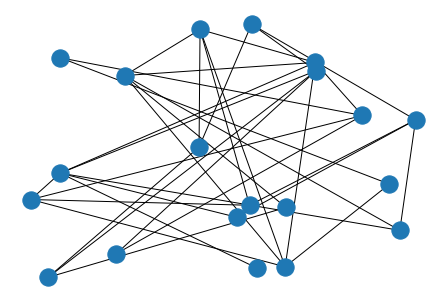

In [65]:
G_test, data_test = generate_testgraph(20,0.2)
graph_vis(G_test, data_test.x, f'test_vis')

610 1293.0041540527343
620 1293.9409956054687
630 1291.977103515625
640 1292.149474609375


KeyboardInterrupt: 

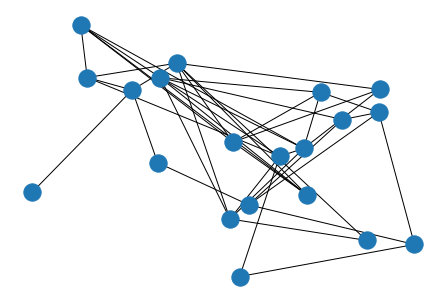

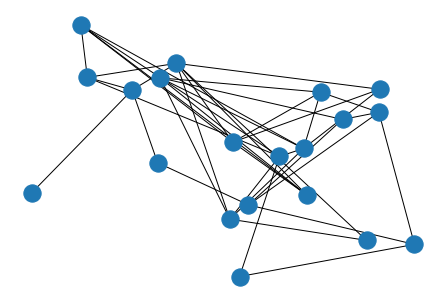

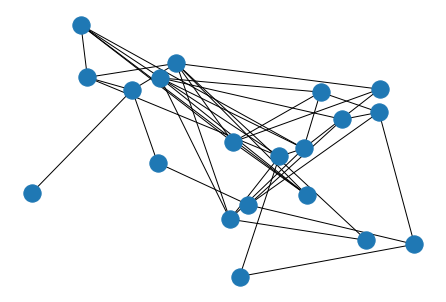

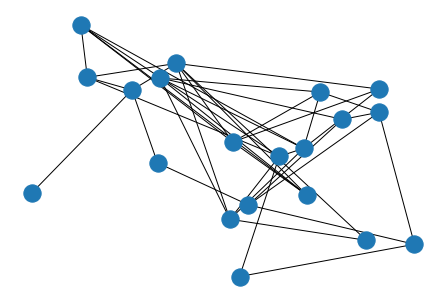

In [77]:
start_epoch = 610
num_epochs = 5000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if start_epoch == 1:
    model = Net().to(device)
else:
    model = torch.load(f'ckpt/epoch_{start_epoch}.pt').to(device)
criterion = EnergyLossVectorized()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.000005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, 0.5)
for epoch in range(start_epoch, num_epochs):
    loss = train(model, criterion, optimizer,loader)
    loss_ep.append(loss)
#     scheduler.step()
    if epoch % 10 == 0:
        torch.save(model, f'ckpt/epoch_{epoch}.pt')
        node_pos = evaluate(model, data_test)
        graph_vis(G_test, node_pos, f'random_30/epoch_{epoch}.png')
        print(epoch, loss)

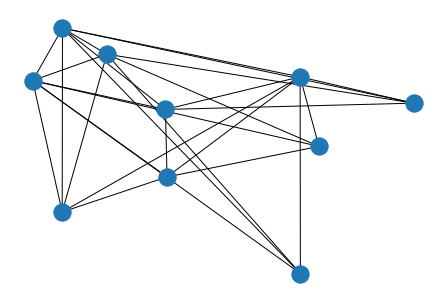

In [107]:
G_test, data_test = generate_testgraph(10,0.5)
node_pos = evaluate(model, data_test)
graph_vis(G_test, node_pos, f'test_vis') 

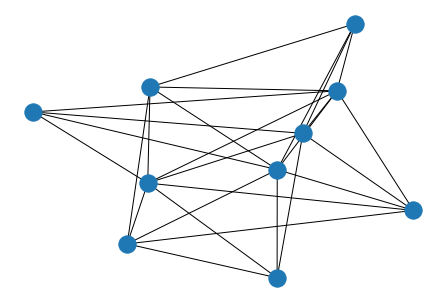

In [108]:
plt.figure()
nx.draw(G_test)

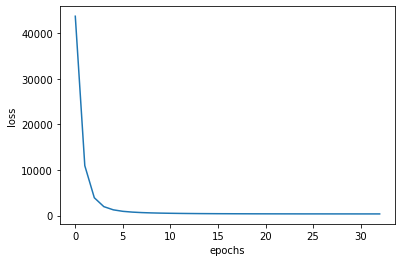

In [18]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(loss_ep)
plt.show()